- Problem Statement: Develop a state-of-the-art question-answering model leveraging the Quora
Question Answer Dataset. The objective is to create an AI system capable of understanding and
generating accurate responses to a variety of user queries, mimicking a human-like interaction.

# Data Set
- df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset Quora-QuAD.jsonl", lines=True)

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE



In [7]:
!pip install fuzzywuzzy

In [5]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16257 sha256=4f986b4d328ee4375e3393493557a3cd1985f3a249884cf5a50d3f94d8efb16a
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


# Reading data and basic stats

In [1]:
!pip install datasets pandas nltk

In [2]:
from datasets import load_dataset

ds = load_dataset("toughdata/quora-question-answer-dataset")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [3]:
df = ds['train'].to_pandas()

In [4]:
print("Number of data points:",df.shape[0])

Number of data points: 56402


In [5]:
df.head()

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB


In [7]:
df.head()

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


In [8]:
df.columns

Index(['question', 'answer'], dtype='object')

In [9]:
df = df.reset_index().rename(columns={'index': 'id'})

In [10]:
df

,id,question,answer
0,0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...
...,...,...,...
56397,56397,"Alexandria Ocasio-Cortez said ""Going by track ...","I think she’s right, one is a homosexual with ..."
56398,56398,Is becoming a doctor financially worth it?,Yes if you want to help people and eliminate p...
56399,56399,Where can one find the best biryani in bangalore?,Biryani crafts.These guys will give proper aut...
56400,56400,Which smartphone is best for middle class people?,Oneplus nord\n[LINKED_TEXT: https://latesttech...


In [11]:
# Display the column names
print(df.columns)


Index(['id', 'question', 'answer'], dtype='object')


In [12]:
# Check for the required column and plot
if 'is_duplicate' in df.columns:
    df['is_duplicate'].value_counts().plot(kind='bar')

    # Add title and labels
    plt.title('Count of Records by Duplicate Status')
    plt.xlabel('Is Duplicate')
    plt.ylabel('Count of Records')
    plt.show()
else:
    print("The 'is_duplicate' column is not present in the DataFrame.")


The 'is_duplicate' column is not present in the DataFrame.


In [13]:
print(' Total number of question pairs for training:\n   {}'.format(len(df)))

 Total number of question pairs for training:
   56402


In [14]:
# Display the column names of the DataFrame
print(df.columns)

# Check if 'is_duplicate' column exists. If not, create it.
if 'is_duplicate' not in df.columns:
    # Assuming 'is_duplicate' column is derived from other columns or data
    # Replace the following line with the actual logic to create 'is_duplicate' column
    df['is_duplicate'] = 0  # Example: Setting all values to 0

print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

Index(['id', 'question', 'answer'], dtype='object')
~> Question pairs are not Similar (is_duplicate = 0):
   100.0%

~> Question pairs are Similar (is_duplicate = 1):
   0.0%


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            56402 non-null  int64 
 1   question      56402 non-null  object
 2   answer        56402 non-null  object
 3   is_duplicate  56402 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


#Number of unique questions

In [21]:
question_answering = pd.Series(df['question'].tolist() + df['answer'].tolist())
unique_qs = len(np.unique(question_answering))
qs_morethan_onetime = np.sum(question_answering.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(question_answering))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(question_answering.value_counts())))

q_vals=question_answering.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 57960

Number of unique questions that appear more than one time: 3537 (6.10248447204969%)

Max number of times a single question is repeated: 106



In [18]:
import pandas as pd


In [22]:
!pip install seaborn



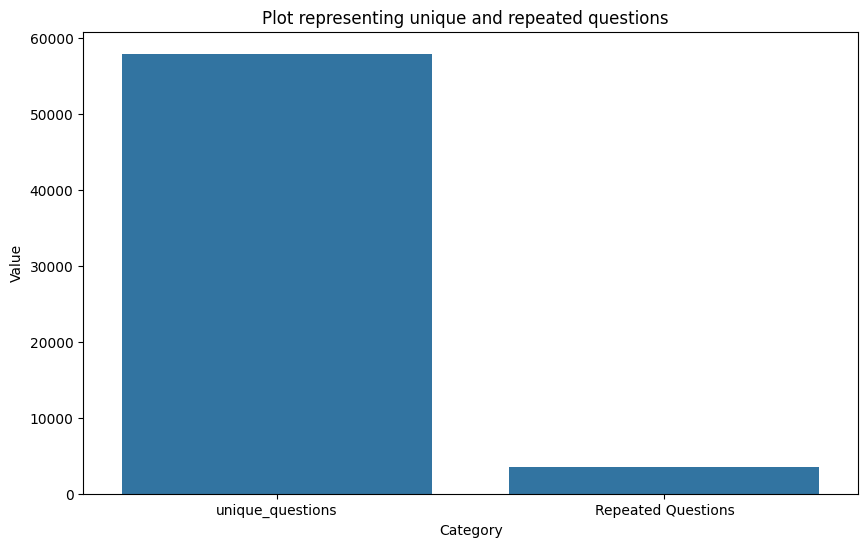

In [23]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
# Creating a DataFrame for seaborn
data = {'Category': x, 'Value': y}
df_temp = pd.DataFrame(data)

# Use the 'x' and 'y' parameters to specify the columns from the DataFrame
sns.barplot(x='Category', y='Value', data=df_temp)
plt.show()

**Checking for Duplicates**

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            56402 non-null  int64 
 1   question      56402 non-null  object
 2   answer        56402 non-null  object
 3   is_duplicate  56402 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


**Checking for Duplicates**

In [25]:
pair_duplicates = df[['question', 'answer']].groupby(['question', 'answer']).size().reset_index(name='count')

# Identify pairs that appear more than once
duplicate_pairs = pair_duplicates[pair_duplicates['count'] > 1]

# Count the number of duplicate pairs
num_duplicate_pairs = duplicate_pairs.shape[0]

print("Number of duplicate question pairs: ", num_duplicate_pairs)

Number of duplicate question pairs:  528


#Number of occurrences of each question

Maximum number of times a single question is repeated: 106



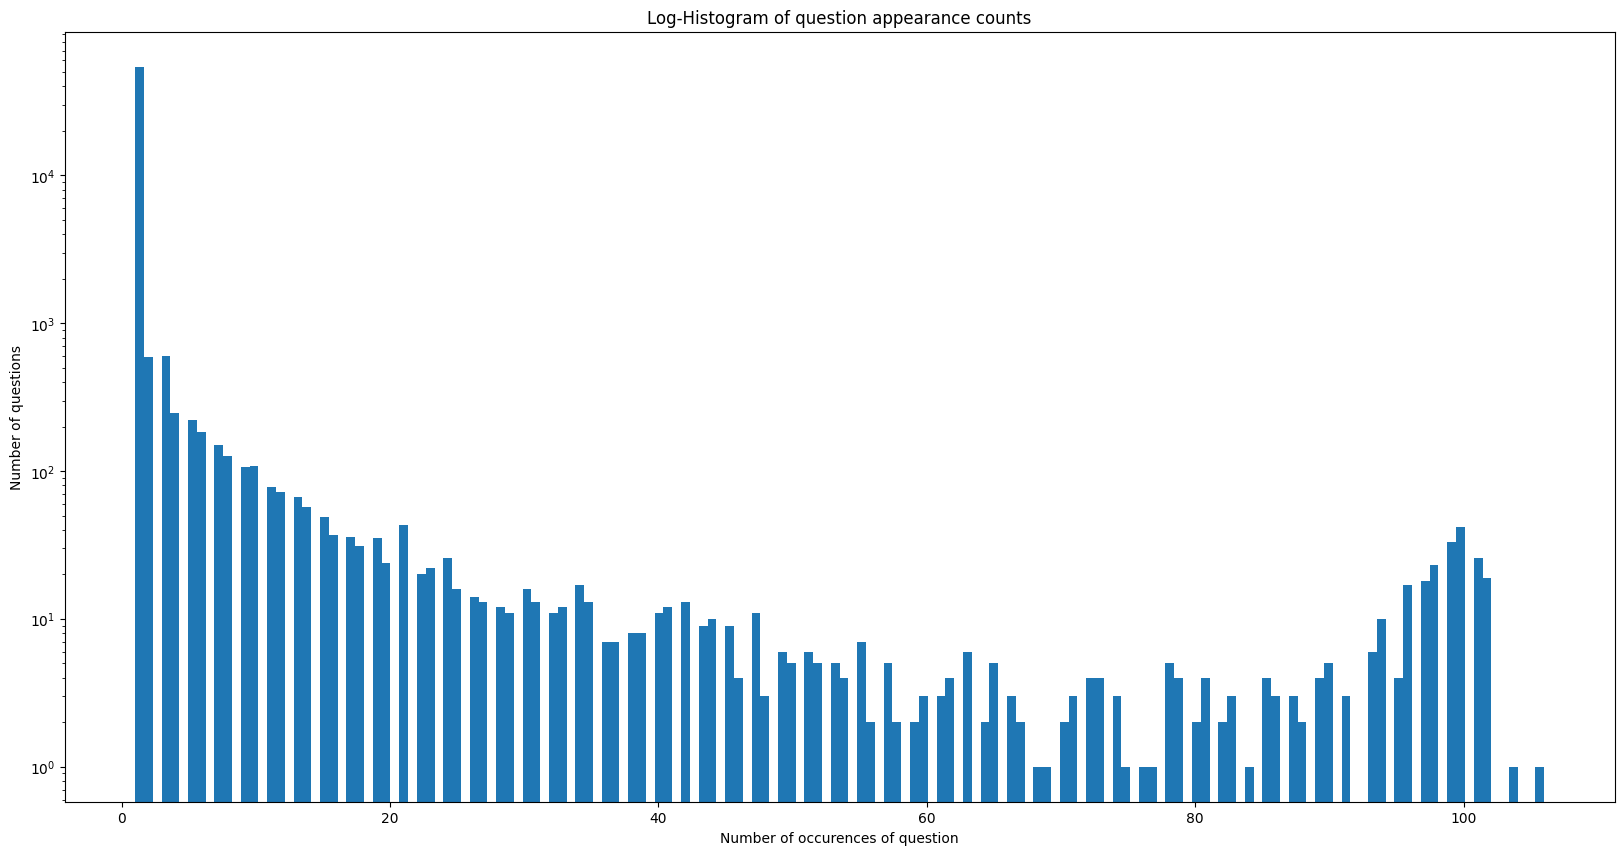

In [26]:
plt.figure(figsize=(20, 10))

plt.hist(question_answering.value_counts(), bins=160)

# Use 'nonpositive' instead of 'nonposy'
plt.yscale('log', nonpositive='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(question_answering.value_counts())))

**Checking for NULL values **

In [27]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(axis=1)] # Use 'axis=1' to specify that the check should be performed across columns
print (nan_rows)

Empty DataFrame
Columns: [id, question, answer, is_duplicate]
Index: []


In [28]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(axis=1)] # Added axis=1
print (nan_rows)

Empty DataFrame
Columns: [id, question, answer, is_duplicate]
Index: []


*Basic Feature Extraction (before cleaning)***

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2


In [29]:
if os.path.isfile("toughdata/quora-question-answer-dataset"):
    df = pd.read_csv("toughdata/quora-question-answer-dataset",encoding='latin-1')
else:
    # Check if 'question1' column exists, if not, use 'question'
    if 'question1' not in df.columns:
        df['question1'] = df['question'] # Creating a 'question1' column from 'question' if it doesn't exist
    if 'question2' not in df.columns:
        df['question2'] = df['question'] # Creating a 'question2' column from 'question' if it doesn't exist

    df['freq_question'] = df.groupby('question')['question'].transform('count')
    df['freq_answer'] = df.groupby('answer')['answer'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    # It looks like these columns don't exist.
    # Creating dummy columns with value 0 to avoid the KeyError.
    # Please replace with the actual column creation if you have the data.
    df['freq_qid1'] = 0
    df['freq_qid2'] = 0

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,question,answer,is_duplicate,question1,question2,freq_question,freq_answer,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_qid1,freq_qid2,freq_q1+q2,freq_q1-q2
0,0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...,0,Why whenever I get in the shower my girlfriend...,Why whenever I get in the shower my girlfriend...,29,1,60,60,12,12,12.0,24.0,0.5,0,0,0,0
1,1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...,0,"What is a proxy, and how can I use one?","What is a proxy, and how can I use one?",100,1,39,39,10,10,10.0,20.0,0.5,0,0,0,0
2,2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n,0,"What song has the lyrics ""someone left the cak...","What song has the lyrics ""someone left the cak...",47,1,65,65,13,13,11.0,22.0,0.5,0,0,0,0
3,3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...,0,I am the owner of an adult website called http...,I am the owner of an adult website called http...,7,1,144,144,24,24,24.0,48.0,0.5,0,0,0,0
4,4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...,0,Does the Bible mention anything about a place ...,Does the Bible mention anything about a place ...,42,1,72,72,12,12,12.0,24.0,0.5,0,0,0,0


# Analysis of some of the extracted features

-  Feature: word_share

In [30]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 158
Number of Questions with minimum length [question2] : 158


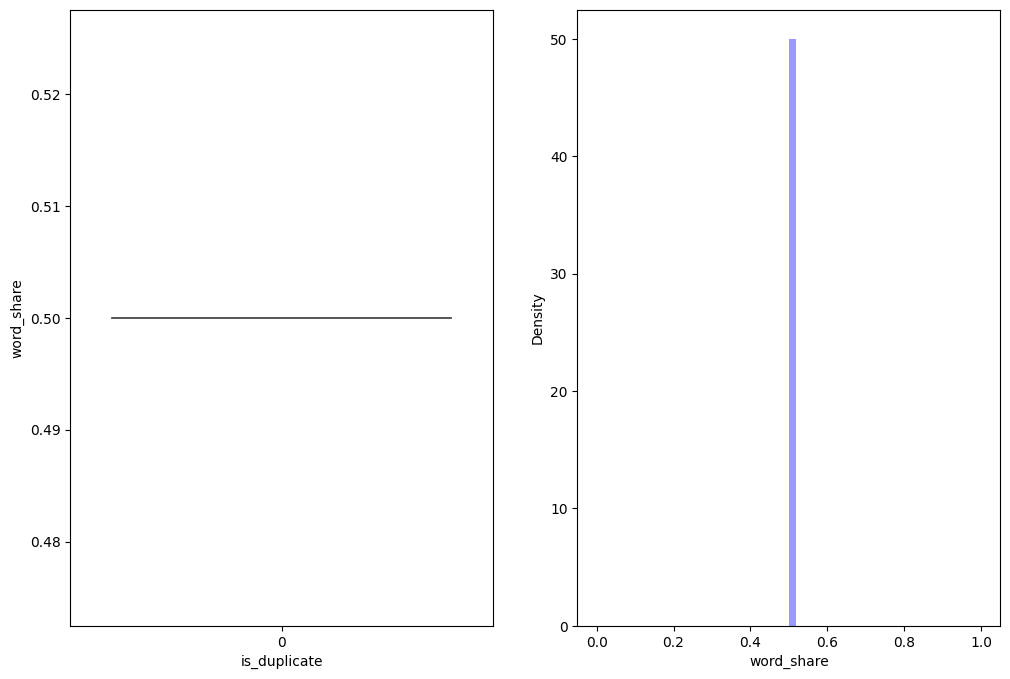

In [31]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

# Preprocessing of Text

- Preprocessing:
    - Removing html tags
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [32]:
!pip install nltk
import nltk

nltk.download('stopwords')

SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)


    porter = PorterStemmer()
    pattern = re.compile('\W')

    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)


    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()


    return x

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

In [33]:
def get_token_features(q1, q2):
    token_features = [0.0]*10

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")

    # Merging Features with dataset

    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)

    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))

    #Computing Fuzzy Features and Merging with Dataset

    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [37]:
import os
import pandas as pd

# Check if the file exists
if os.path.isfile("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl"):
    df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

    # Print columns to ensure we have the correct column names
    print("Columns in the DataFrame:", df.columns)

    # Apply preprocessing if the correct column names are present
    if 'question' in df.columns and 'question2' in df.columns:
        df['question'] = df['question'].fillna("").apply(preprocess)
        df['question2'] = df['question2'].fillna("").apply(preprocess)
        df = extract_features(df)
    else:
        print("The required columns are not present in the DataFrame.")

    # Reload the DataFrame
    df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

# Display the first two rows of the DataFrame
df.head(2)


Extracting features for train:
Columns in the DataFrame: Index(['question', 'answer'], dtype='object')
The required columns are not present in the DataFrame.


,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...


3.5.1 Analysis of extracted features

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [38]:
# Check if the file exists
if os.path.isfile("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl"):
    df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

    # Print columns to ensure we have the correct column names
    print("Columns in the DataFrame:", df.columns)

    # Apply preprocessing if the correct column names are present
    if 'question' in df.columns and 'question2' in df.columns:
        df['question'] = df['question'].fillna("").apply(preprocess)
        df['question2'] = df['question2'].fillna("").apply(preprocess)
        df = extract_features(df)
    else:
        print("The required columns are not present in the DataFrame.")

    # Reload the DataFrame
    df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

# Check if 'is_duplicate' column is present
if 'is_duplicate' in df.columns:
    df_duplicate = df[df['is_duplicate'] == 1]
    dfp_nonduplicate = df[df['is_duplicate'] == 0]

    # Converting 2D array of q1 and q2 and flatten the array
    p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
    n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

    print("Number of data points in class 1 (duplicate pairs) :", len(p))
    print("Number of data points in class 0 (non duplicate pairs) :", len(n))

    # Saving the np array into a text file
    np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
    np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')
else:
    print("The 'is_duplicate' column is not present in the DataFrame.")


Extracting features for train:
Columns in the DataFrame: Index(['question', 'answer'], dtype='object')
The required columns are not present in the DataFrame.
The 'is_duplicate' column is not present in the DataFrame.


In [42]:
import os
import pandas as pd
import numpy as np
from os import path
from wordcloud import STOPWORDS

# Load the dataset
df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

# Print columns to ensure we have the correct column names
print("Columns in the DataFrame:", df.columns)

# Ensure the required columns are present
if 'is_duplicate' in df.columns and 'question1' in df.columns and 'question2' in df.columns:
    df_duplicate = df[df['is_duplicate'] == 1]
    dfp_nonduplicate = df[df['is_duplicate'] == 0]

    # Converting 2D array of q1 and q2 and flatten the array
    p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
    n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

    print("Number of data points in class 1 (duplicate pairs):", len(p))
    print("Number of data points in class 0 (non duplicate pairs):", len(n))

    # Saving the np array into a text file
    np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
    np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')
else:
    print("The required columns are not present in the DataFrame.")

# Check if the text files exist before proceeding
if path.exists('train_p.txt') and path.exists('train_n.txt'):
    # Reading the text files and removing the Stop Words
    with open('train_p.txt', 'r') as file:
        textp_w = file.read()

    with open('train_n.txt', 'r') as file:
        textn_w = file.read()

    stopwords = set(STOPWORDS)
    stopwords.add("said")
    stopwords.add("br")
    stopwords.add(" ")
    stopwords.remove("not")
    stopwords.remove("no")
    # stopwords.remove("good")
    # stopwords.remove("love")
    stopwords.remove("like")
    # stopwords.remove("best")
    # stopwords.remove("!")

    # Removing stop words from the texts
    textp_w = ' '.join([word for word in textp_w.split() if word.lower() not in stopwords])
    textn_w = ' '.join([word for word in textn_w.split() if word.lower() not in stopwords])

    print("Total number of words in duplicate pair questions:", len(textp_w.split()))
    print("Total number of words in non duplicate pair questions:", len(textn_w.split()))
else:
    print("The text files do not exist.")



Columns in the DataFrame: Index(['question', 'answer'], dtype='object')
The required columns are not present in the DataFrame.
The text files do not exist.


3.5.2 Visualization


3.6 Featurizing text data with tfidf weighted word-vectors

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [49]:
df.head()

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure the DataFrame contains 'question' and 'answer' columns
if 'question' in df.columns and 'answer' in df.columns:
    # Merge texts
    questions = list(df['question']) + list(df['answer'])

    # Initialize and fit the TfidfVectorizer
    tfidf = TfidfVectorizer(lowercase=False)
    tfidf.fit_transform(questions)

    # Create a dictionary with word as key and tf-idf score as value
    word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

    print("Sample tf-idf scores:")
    for word, score in list(word2tfidf.items())[:10]:
        print(f"{word}: {score}")
else:
    print("The required columns 'question' and 'answer' are not present in the DataFrame.")



Sample tf-idf scores:
00: 6.852672427512522
000: 5.332943129037052
0000: 11.534803654636741
000000: 11.247121582184961
00000000: 11.940268762744907
0000000000: 11.940268762744907
000000000000: 11.940268762744907
00000000000000000000000000000000000000000000000000000000000002: 11.940268762744907
00000000000000008222222222: 11.940268762744907
000000000000000It: 11.940268762744907


- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [52]:
import en_core_web_sm

In [57]:
import spacy
import numpy as np
from tqdm import tqdm
import en_core_web_lg

# Load the larger model with vectors
nlp = en_core_web_lg.load()

vecs1 = []
for qu1 in tqdm(list(df['question'])):
    doc1 = nlp(qu1)
    # 300 is the number of dimensions of vectors in en_vectors_web_lg
    mean_vec1 = np.zeros((300,))
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except KeyError:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1 / len(doc1)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 56402/56402 [13:18<00:00, 70.60it/s]


In [56]:
!pip install spacy
!python -m spacy download en_core_web_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 787.0 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [58]:
import spacy
import numpy as np
from tqdm import tqdm

# Load the larger model with vectors
nlp = spacy.load("en_core_web_lg")

vecs1 = []
for qu1 in tqdm(list(df['question'])):
    doc1 = nlp(qu1)
    # 300 is the number of dimensions of vectors in en_core_web_lg
    mean_vec1 = np.zeros((300,))
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf.get(str(word1), 0)
        except KeyError:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1 / len(doc1) if len(doc1) > 0 else mean_vec1
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 56402/56402 [12:49<00:00, 73.28it/s]


In [60]:
import spacy
import numpy as np

from tqdm import tqdm

# Load the larger model with vectors
nlp = spacy.load("en_core_web_lg")

# List to hold vectors
vecs2 = []

# Process each 'answer' in the DataFrame
for qu2 in tqdm(list(df['answer'])):
    doc2 = nlp(qu2)
    # 300 is the number of dimensions of vectors in en_core_web_lg
    mean_vec2 = np.zeros((300,))
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf.get(str(word2), 0)
        except KeyError:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2 / len(doc2) if len(doc2) > 0 else mean_vec2
    vecs2.append(mean_vec2)


100%|██████████| 56402/56402 [45:31<00:00, 20.65it/s]


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

### Question Answer Application
The goal of Question Answering is to find the answer to a question given a question and an accompanying context. The predicted answer will be either a span of text from the context or an empty string (indicating the question cannot be answered from the context).

In [66]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=a5

In [67]:
import pandas as pd

df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

In [68]:
import logging

from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs

In [78]:
!pip install datasets
import json
from datasets import load_dataset

dataset = load_dataset("toughdata/quora-question-answer-dataset")
# Load the dataset from the Hugging Face Hub

# Access the training data (assuming it's in a split called 'train')
train = dataset['train']

# Now you can process the data as needed
# For example, to print the first example:
print(train[0])

{'question': 'Why whenever I get in the shower my girlfriend want to join?', 'answer': 'Isn’t it awful? You would swear that there wasn’t enough hot water to go around!\n'}


In [80]:
train

Dataset({
    features: ['question', 'answer'],
    num_rows: 56402
})

In [83]:
!pip install datasets
import json
from datasets import load_dataset

# Load the dataset from the Hugging Face Hub
dataset = load_dataset("toughdata/quora-question-answer-dataset")

# Save the training data to a local jsonl file
dataset['train'].to_json("quora-question-answer-dataset.jsonl")

# Now you can open the local file
with open("quora-question-answer-dataset.jsonl", "r") as read_file:
    test = [json.loads(line) for line in read_file]

Creating json from Arrow format:   0%|          | 0/57 [00:00<?, ?ba/s]

In [84]:
test

[{'question': 'Why whenever I get in the shower my girlfriend want to join?',
  'answer': 'Isn’t it awful? You would swear that there wasn’t enough hot water to go around!\n'},
 {'question': 'What is a proxy, and how can I use one?',
  'answer': 'A proxy server is a system or router that provides a gateway between users and the internet. Therefore, it helps prevent cyber attackers from entering a private network. It is a server, referred to as an “intermediary” because it goes between end-users and the web pages they visit online.\n When a computer connects to the internet, it uses an IP address. This is similar to your home’s street address, telling incoming data where to go and marking outgoing data with a return address for other devices to authenticate. A proxy server is essentially a computer on the internet that has an IP address of its own.\n How a Proxy Works\nBecause a proxy server has its own IP address, it acts as a go-between for a computer and the internet. Your computer k

In [85]:
import logging

from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs

In [86]:
model_type="bert"
model_name= "bert-base-cased"

if model_type == "bert":
    model_name = "bert-base-cased"

elif model_type == "roberta":
    model_name = "roberta-base"

elif model_type == "distilbert":
    model_name = "distilbert-base-cased"

elif model_type == "distilroberta":
    model_type = "roberta"
    model_name = "distilroberta-base"

elif model_type == "electra-base":
    model_type = "electra"
    model_name = "google/electra-base-discriminator"

elif model_type == "electra-small":
    model_type = "electra"
    model_name = "google/electra-small-discriminator"

elif model_type == "xlnet":
    model_name = "xlnet-base-cased"

In [87]:
# Configure the model
model_args = QuestionAnsweringArgs()
model_args.train_batch_size = 16
model_args.evaluate_during_training = True
model_args.n_best_size=3
model_args.num_train_epochs=5


In [89]:
### Advanced Methodology
train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "use_cached_eval_features": True,
    "output_dir": f"outputs/{model_type}",
    "best_model_dir": f"outputs/{model_type}/best_model",
    "evaluate_during_training": True,
    "max_seq_length": 128,
    "num_train_epochs": 5,
    "evaluate_during_training_steps": 1000,
    "wandb_project": "Question Answer Application",
    "wandb_kwargs": {"name": model_name},
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "n_best_size":3,
    # "use_early_stopping": True,
    # "early_stopping_metric": "mcc",
    # "n_gpu": 2,
    # "manual_seed": 4,
    # "use_multiprocessing": False,
    "train_batch_size": 128,
    "eval_batch_size": 64,
    # "config": {
    #     "output_hidden_states": True
    # }
}

In [90]:
import logging

from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs

# ... (rest of your code)

model = QuestionAnsweringModel(model_type, model_name, args=train_args, use_cuda=False)  # Explicitly disable CUDA

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
### Remove output folder
!rm -rf outputs

In [96]:
# Example test data with the correct structure
test = [
    {
        "context": "Technology and computing",
        "qas": [
            {
                "id": "1",
                "question": "What is AI?",
                "answers": [{"text": "Artificial Intelligence", "answer_start": 0}]
            }
        ]
    },
    {
        "context": "Technology and computing",
        "qas": [
            {
                "id": "2",
                "question": "What is ML?",
                "answers": [{"text": "Machine Learning", "answer_start": 0}]
            }
        ]
    }
]

# Evaluate the model
result, texts = model.eval_model(test)

# Print the results
print("Evaluation Result:", result)
print("Texts:", texts)


add example index and unique id: 100%|██████████| 2/2 [00:00<00:00, 12035.31it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluation Result: {'correct': 0, 'similar': 0, 'incorrect': 2, 'eval_loss': -0.4356401264667511}
Texts: {'correct_text': {}, 'similar_text': {}, 'incorrect_text': {'1': {'truth': 'Artificial Intelligence', 'predicted': 'empty', 'question': 'What is AI?'}, '2': {'truth': 'Machine Learning', 'predicted': 'empty', 'question': 'What is ML?'}}}


In [97]:
result

{'correct': 0, 'similar': 0, 'incorrect': 2, 'eval_loss': -0.4356401264667511}

In [98]:
texts

{'correct_text': {},
 'similar_text': {},
 'incorrect_text': {'1': {'truth': 'Artificial Intelligence',
   'predicted': 'empty',
   'question': 'What is AI?'},
  '2': {'truth': 'Machine Learning',
   'predicted': 'empty',
   'question': 'What is ML?'}}}

In [99]:
# Make predictions with the model
to_predict = [
    {
        "context": "Vin is a Mistborn of great power and skill.",
        "qas": [
            {
                "question": "What is Vin's speciality?",
                "id": "0",
            }
        ],
    }
]

In [100]:
answers, probabilities = model.predict(to_predict)

print(answers)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 8683.86it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': '0', 'answer': ['empty']}]


In [103]:
from datasets import load_dataset

ds = load_dataset("toughdata/quora-question-answer-dataset")

In [104]:
df = ds['train'].to_pandas()

In [105]:
df.shape

(56402, 2)

In [106]:
df.head()

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


In [107]:
df.columns

Index(['question', 'answer'], dtype='object')

In [108]:
df.tail

<bound method NDFrame.tail of                                                 question  \
0      Why whenever I get in the shower my girlfriend...   
1                What is a proxy, and how can I use one?   
2      What song has the lyrics "someone left the cak...   
3      I am the owner of an adult website called http...   
4      Does the Bible mention anything about a place ...   
...                                                  ...   
56397  Alexandria Ocasio-Cortez said "Going by track ...   
56398         Is becoming a doctor financially worth it?   
56399  Where can one find the best biryani in bangalore?   
56400  Which smartphone is best for middle class people?   
56401  Why am I always rejected by the men I am inter...   

                                                  answer  
0      Isn’t it awful? You would swear that there was...  
1      A proxy server is a system or router that prov...  
2                                     MacArthur's Park\n  
3      Don't let apps that are liers put adds on your...  
4      St. John in the book of Revelation mentions an...  
...                                                  ...  
56397  I think she’s right, one is a homosexual with ...  
56398  Yes if you want to help people and eliminate p...  
56399  Biryani crafts.These guys will give proper aut...  
56400  Oneplus nord\n[LINKED_TEXT: https://latesttech...  
56401  I am a man, just not competitively and I will ...  

[56402 rows x 2 columns]>

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB


In [110]:
df

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...
...,...,...
56397,"Alexandria Ocasio-Cortez said ""Going by track ...","I think she’s right, one is a homosexual with ..."
56398,Is becoming a doctor financially worth it?,Yes if you want to help people and eliminate p...
56399,Where can one find the best biryani in bangalore?,Biryani crafts.These guys will give proper aut...
56400,Which smartphone is best for middle class people?,Oneplus nord\n[LINKED_TEXT: https://latesttech...


In [111]:
df.describe()

,question,answer
count,56402,56402
unique,3234,54726
top,Would Hillary Clinton have made a better Presi...,No\n
freq,106,89


In [112]:
df.isnull().sum()

question    0
answer      0
dtype: int64

In [113]:
df.question.unique

<bound method Series.unique of 0        Why whenever I get in the shower my girlfriend...
1                  What is a proxy, and how can I use one?
2        What song has the lyrics "someone left the cak...
3        I am the owner of an adult website called http...
4        Does the Bible mention anything about a place ...
                               ...                        
56397    Alexandria Ocasio-Cortez said "Going by track ...
56398           Is becoming a doctor financially worth it?
56399    Where can one find the best biryani in bangalore?
56400    Which smartphone is best for middle class people?
56401    Why am I always rejected by the men I am inter...
Name: question, Length: 56402, dtype: object>

In [114]:
df.answer.unique

<bound method Series.unique of 0        Isn’t it awful? You would swear that there was...
1        A proxy server is a system or router that prov...
2                                       MacArthur's Park\n
3        Don't let apps that are liers put adds on your...
4        St. John in the book of Revelation mentions an...
                               ...                        
56397    I think she’s right, one is a homosexual with ...
56398    Yes if you want to help people and eliminate p...
56399    Biryani crafts.These guys will give proper aut...
56400    Oneplus nord\n[LINKED_TEXT: https://latesttech...
56401    I am a man, just not competitively and I will ...
Name: answer, Length: 56402, dtype: object>

In [115]:
df.isnull().sum()

question    0
answer      0
dtype: int64

In [116]:
df.isnull().sum().sort_values(ascending=False)


question    0
answer      0
dtype: int64

In [117]:
df = df.drop(columns=['id', 'url'], errors = 'ignore')
df

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...
...,...,...
56397,"Alexandria Ocasio-Cortez said ""Going by track ...","I think she’s right, one is a homosexual with ..."
56398,Is becoming a doctor financially worth it?,Yes if you want to help people and eliminate p...
56399,Where can one find the best biryani in bangalore?,Biryani crafts.These guys will give proper aut...
56400,Which smartphone is best for middle class people?,Oneplus nord\n[LINKED_TEXT: https://latesttech...


In [118]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [119]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['question'] = df['question'].apply(preprocess)
df['answer'] = df['answer'].apply(preprocess)


In [120]:
df.head()

,question,answer
0,why whenever i get in the shower my girlfriend...,isn ’ t it awful ? you would swear that there ...
1,"what is a proxy , and how can i use one ?",a proxy server is a system or router that prov...
2,what song ha the lyric `` someone left the cak...,macarthur 's park
3,i am the owner of an adult website called http...,do n't let apps that are liers put add on your...
4,doe the bible mention anything about a place `...,st. john in the book of revelation mention an ...


In [121]:
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
df['answer_length'] = df['answer'].apply(lambda x: len(x.split()))

In [122]:
df

,question,answer,question_length,answer_length
0,why whenever i get in the shower my girlfriend...,isn ’ t it awful ? you would swear that there ...,13,21
1,"what is a proxy , and how can i use one ?",a proxy server is a system or router that prov...,12,326
2,what song ha the lyric `` someone left the cak...,macarthur 's park,16,3
3,i am the owner of an adult website called http...,do n't let apps that are liers put add on your...,28,134
4,doe the bible mention anything about a place `...,st. john in the book of revelation mention an ...,15,34
...,...,...,...,...
56397,alexandria ocasio-cortez said `` going by trac...,"i think she ’ s right , one is a homosexual wi...",40,36
56398,is becoming a doctor financially worth it ?,yes if you want to help people and eliminate p...,8,131
56399,where can one find the best biryani in bangalo...,biryani crafts.these guy will give proper auth...,10,11
56400,which smartphone is best for middle class peop...,oneplus nord [ linked_text : http : //latestte...,9,20


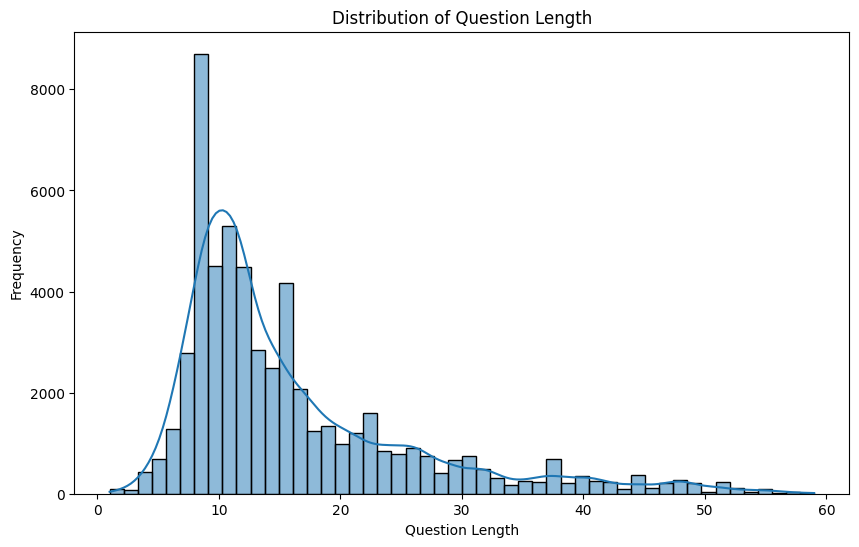

In [123]:
plt.figure(figsize=(10, 6))
sns.histplot(df['question_length'], bins=50, kde=True)
plt.title('Distribution of Question Length')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

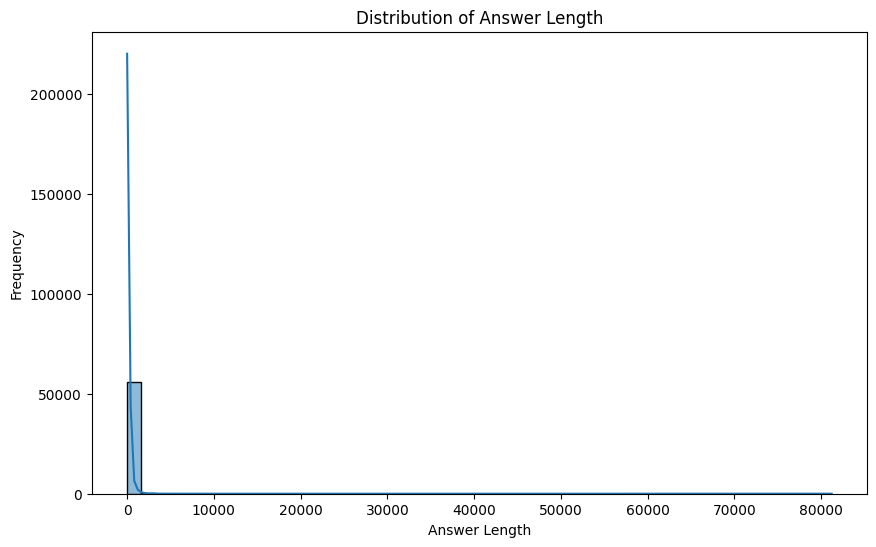

In [124]:
plt.figure(figsize=(10, 6))
sns.histplot(df['answer_length'], bins = 50, kde = True)
plt.title('Distribution of Answer Length')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.show()

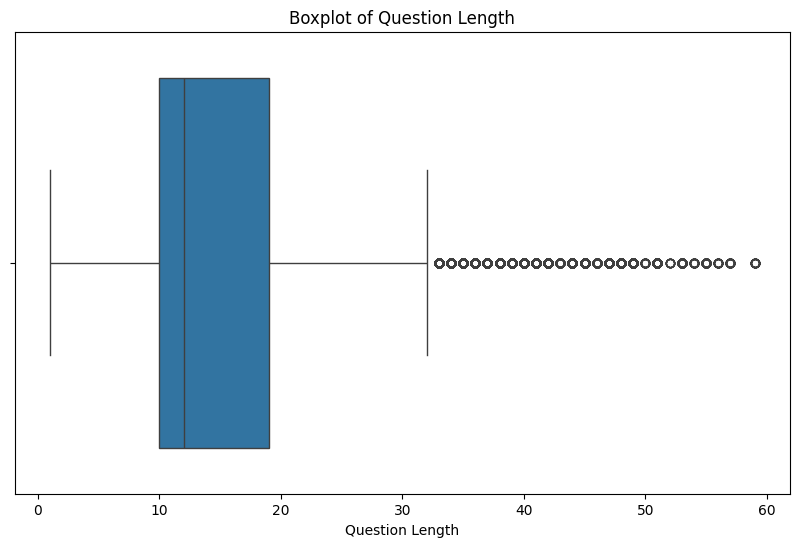

In [125]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['question_length'])
plt.title('Boxplot of Question Length')
plt.xlabel('Question Length')
plt.show()

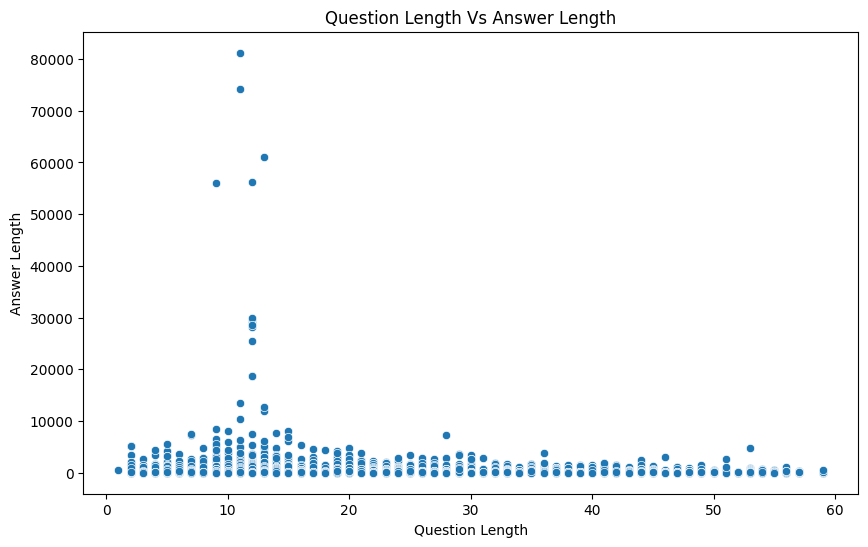

In [126]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = df, x = 'question_length', y = 'answer_length')
plt.title('Question Length Vs Answer Length')
plt.xlabel('Question Length')
plt.ylabel('Answer Length')
plt.show()

In [127]:
df.columns

Index(['question', 'answer', 'question_length', 'answer_length'], dtype='object')

In [128]:
cat_col = [col for col in df.columns if df[col].dtype == 'object']

In [129]:
num_col = [col for col in df.columns if df[col].dtype != 'object']

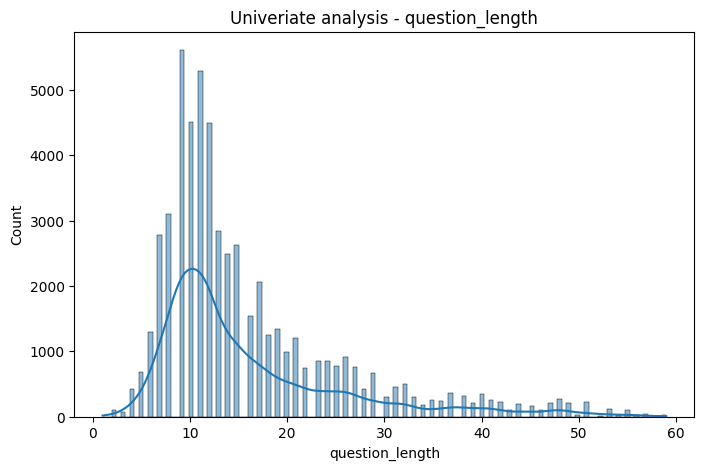

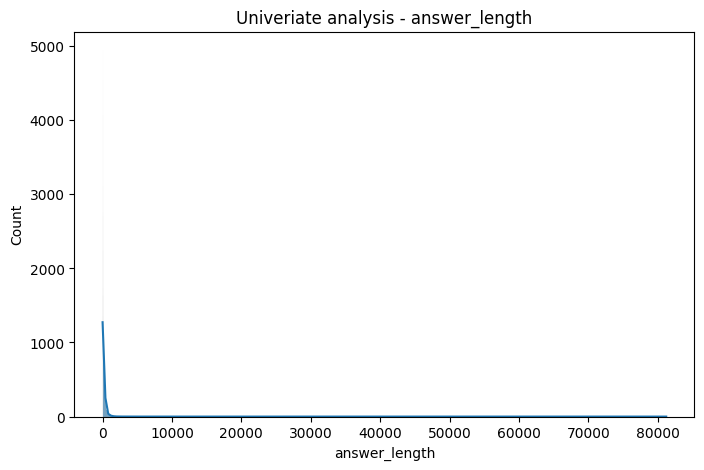

In [130]:
for column in num_col:
  plt.figure(figsize = (8, 5))
  sns.histplot(df[column], kde = True)
  plt.title(f"Univeriate analysis - {column}")
  plt.show()

In [131]:
for i in df[cat_col].columns:
  x = df[i].unique()
  print(f"{i} : {x}")
  print()

question : ['why whenever i get in the shower my girlfriend want to join ?'
 'what is a proxy , and how can i use one ?'
 "what song ha the lyric `` someone left the cake out in the rain '' ?"
 ...
 "what source have previously revealed information about lorraine stanley 's exit from eastenders ?"
 'is the piperinox weight loss supplement effective and worth buying ?'
 'are there any solid , ionic or covalent , that are more soluble in pure h2o than they are in a strong acid or strong alkali aqueous solution ?']

answer : ['isn ’ t it awful ? you would swear that there wasn ’ t enough hot water to go around !'
 'a proxy server is a system or router that provides a gateway between user and the internet . therefore , it help prevent cyber attacker from entering a private network . it is a server , referred to a an “ intermediary ” because it go between end-users and the web page they visit online . when a computer connects to the internet , it us an ip address . this is similar to your h

In [132]:
df

,question,answer,question_length,answer_length
0,why whenever i get in the shower my girlfriend...,isn ’ t it awful ? you would swear that there ...,13,21
1,"what is a proxy , and how can i use one ?",a proxy server is a system or router that prov...,12,326
2,what song ha the lyric `` someone left the cak...,macarthur 's park,16,3
3,i am the owner of an adult website called http...,do n't let apps that are liers put add on your...,28,134
4,doe the bible mention anything about a place `...,st. john in the book of revelation mention an ...,15,34
...,...,...,...,...
56397,alexandria ocasio-cortez said `` going by trac...,"i think she ’ s right , one is a homosexual wi...",40,36
56398,is becoming a doctor financially worth it ?,yes if you want to help people and eliminate p...,8,131
56399,where can one find the best biryani in bangalo...,biryani crafts.these guy will give proper auth...,10,11
56400,which smartphone is best for middle class peop...,oneplus nord [ linked_text : http : //latestte...,9,20


In [133]:
df.columns

Index(['question', 'answer', 'question_length', 'answer_length'], dtype='object')

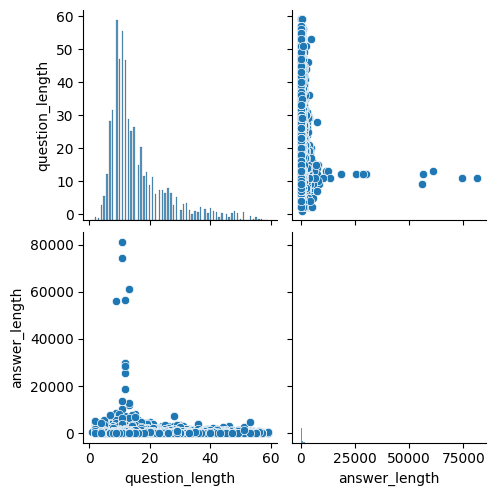

In [134]:
sns.pairplot(df)

# Conclusion


- Importing Libraries: Imported vital libraries which include numpy, pandas, seaborn, matplotlib, and others for facts manipulation and visualization.
- Reading Data: loaded the Quora Question Answer Dataset.
- Basic Data Exploration: explored the dataset, such as checking its form, columns, and any missing values.
- Feature Extraction: created new functions based totally on the text records, together with token capabilities and fuzzy functions.
- Preprocessing:  preprocessed the text by means of casting off HTML tags, punctuations, and stopwords, and finished stemming.
- Visualization: visualized a number of the features and distributions within the dataset.
Corrections and Additions
Let's deal with a few points of script to ensure it runs smoothly:

Remove Duplicate Imports and Fix Imports:

Remove duplicate distance, PorterStemmer, and BeautifulSoup imports.
Ensure all required applications are imported at the beginning of the script.
Remove Unnecessary Comments:

Clean up commented code to make it greater readable.
Fix Dataset Loading:

Ensure the dataset is loaded correctly and deal with any potential issues with column names.
Check for Missing Columns:

Add checks for the presence of essential columns before proceeding with operations that rely upon them.
Consistent Preprocessing:

Ensure preprocessing steps are carried out continually throughout the whole dataset.
Plotting:

Add any lacking plotting functions or accurate any issues with current plots.